# Estimate generation 

- Use advanced models for generation estimation in the Global Power Plant Database.
- Primary model is a two-hidden-layer neural network.

In [1]:
# import what we'll need and set parameters

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from sklearn.model_selection import train_test_split
from sklearn import metrics
from skimage import io
import pydot

GPPD_FILENAME = '../../output_database/global_power_plant_database.csv'
WEIGHTS_FILE = "model/estimate_generation.h5"
VALIDATION_FRACTION = 0.2


Using TensorFlow backend.


In [2]:
# set up fuel colors

fuel_color = { 'Biomass':'#33a02c',
                'Coal':'sienna',
                'Cogeneration':'#e31a1c',
                'Gas':'#a6cee3',
                'Geothermal':'#b2df8a',
                'Hydro':'#1f78b4',
                'Nuclear':'#6a3d9a',
                'Oil':'black',
                'Other':'gray',
                'Petcoke':'#fb9a99',
                'Solar':'#ffff99',
                'Storage':'#b15928',
                'Waste':'#fdbf6f',
                'Wind':'#ff7f00'
                }

In [3]:
# read in database
df = pd.read_csv(GPPD_FILENAME)
df.head()

country country_long                                               name  \
0     AFG  Afghanistan       Kajaki Hydroelectric Power Plant Afghanistan   
1     AFG  Afghanistan      Mahipar Hydroelectric Power Plant Afghanistan   
2     AFG  Afghanistan   Naghlu Dam Hydroelectric Power Plant Afghanistan   
3     AFG  Afghanistan  Nangarhar (Darunta) Hydroelectric Power Plant ...   
4     AFG  Afghanistan            Northwest Kabul Power Plant Afghanistan   

      gppd_idnr  capacity_mw  latitude  longitude  fuel1 fuel2 fuel3  \
0  GEODB0040538        33.00   32.3220    65.1190  Hydro   NaN   NaN   
1  GEODB0040541        66.00   34.5560    69.4787  Hydro   NaN   NaN   
2  GEODB0040534       100.00   34.6410    69.7170  Hydro   NaN   NaN   
3  GEODB0040536        11.55   34.4847    70.3633  Hydro   NaN   NaN   
4  GEODB0040540        42.00   34.5638    69.1134    Gas   NaN   NaN   

             ...            owner  source                                 url  \
0            ...              NaN   GEODB  http://globalenergyobservatory.org   
1            ...              NaN   GEODB  http://globalenergyobservatory.org   
2            ...              NaN   GEODB  http://globalenergyobservatory.org   
3            ...              NaN   GEODB  http://globalenergyobservatory.org   
4            ...              NaN   GEODB  http://globalenergyobservatory.org   

  geolocation_source year_of_capacity_data generation_gwh_2013  \
0              GEODB                2017.0                 NaN   
1              GEODB                2017.0                 NaN   
2              GEODB                2017.0                 NaN   
3              GEODB                2017.0                 NaN   
4              GEODB                2017.0                 NaN   

   generation_gwh_2014  generation_gwh_2015  generation_gwh_2016  \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2                  NaN                  NaN                  NaN   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   

   estimated_generation_gwh  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  

[5 rows x 22 columns]

In [4]:
# show count for number of valid entries in each column
df.count()

country                     25733
country_long                25733
name                        25713
gppd_idnr                   25733
capacity_mw                 25733
latitude                    25733
longitude                   25733
fuel1                       25733
fuel2                        1700
fuel3                         295
fuel4                         107
commissioning_year          14009
owner                       17157
source                      25733
url                         25733
geolocation_source          25733
year_of_capacity_data       16141
generation_gwh_2013           439
generation_gwh_2014           455
generation_gwh_2015           958
generation_gwh_2016          8326
estimated_generation_gwh    24643
dtype: int64

In [5]:
# prepare data for training
# don't include plants with zero generation (set a minimum capacity factor > 0)
# (this may simply result from missing data)
# should address this issue in the future!

MIN_CAPACITY_FACTOR = 0.01
MAX_CAPACITY_FACTOR = 1.0

# create new data frame with relevant predictor variable (X) columns and 2016 generation
# clean data frame by removing NaNs
cols_to_include = ['capacity_mw','latitude','longitude','commissioning_year','fuel1','generation_gwh_2016']
df_clean = df[cols_to_include].dropna(how='any')

# convert 2016 generation into capacity factor and remove rows with erroneous capacity factors
df_clean['capacity_factor'] = df_clean.apply(lambda row:row['generation_gwh_2016']/(24.0*365.0*0.001*row['capacity_mw']),axis=1)
df_clean = df_clean[df_clean.capacity_factor >= MIN_CAPACITY_FACTOR]
df_clean = df_clean[df_clean.capacity_factor <= MAX_CAPACITY_FACTOR]
y_data_generation = df_clean['generation_gwh_2016'].as_matrix()
df_clean = df_clean.drop('generation_gwh_2016',axis=1)

# convert fuel1 data (which is categorical) to one-hot encoding
one_hot = pd.get_dummies(df_clean['fuel1'])
df_clean = df_clean.join(one_hot)
df_clean = df_clean.drop('fuel1',axis=1)

# create np arrays from data frame
y_data = df_clean['capacity_factor'].as_matrix()
df_clean = df_clean.drop('capacity_factor',axis=1)
X_data = df_clean.as_matrix()

# set up fuel name array
fuel_name_list = list(df_clean)[4:]

# show results
print(X_data[0])
print(y_data[0])
print(y_data_generation[0])
print(len(X_data))
print(len(y_data))
print(len(y_data_generation))

df_clean.head()

[  2.89000000e+02   4.72078000e+01   1.10057000e+01   1.98100000e+03
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
0.0469225482296
118.791
6904
6904
6904


capacity_mw  latitude  longitude  commissioning_year  Biomass  Coal  \
760         289.0   47.2078    11.0057              1981.0        0     0   
761         500.0   47.2696    10.9678              1981.0        0     0   
7854       1480.0   53.8506     9.3450              1986.0        0     0   
7868        717.0   51.6370     7.6191              1981.0        0     1   
7918       2427.0   51.4163    14.5619              2012.0        0     1   

      Cogeneration  Gas  Geothermal  Hydro  Nuclear  Oil  Other  Petcoke  \
760              0    0           0      1        0    0      0        0   
761              0    0           0      1        0    0      0        0   
7854             0    0           0      0        1    0      0        0   
7868             0    0           0      0        0    0      0        0   
7918             0    0           0      0        0    0      0        0   

      Solar  Storage  Waste  Wind  
760       0        0      0     0  
761       0        0      0     0  
7854      0        0      0     0  
7868      0        0      0     0  
7918      0        0      0     0

Y data max: 0.998536954444, min: 0.010049329739


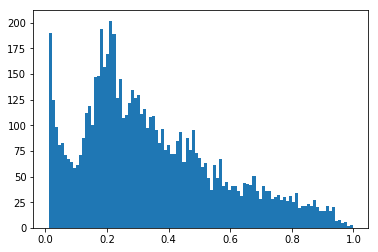

In [6]:
# examine capacity-factor-based training data to confirm valid capacity factors

print(u"Y data max: {0}, min: {1}".format(y_data.max(),y_data.min()))
plt.hist(y_data,bins=100)
plt.show()

Y data (generation) max: 32377.477, min: 0.115


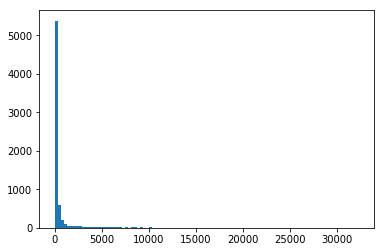

In [7]:
# examine generation-based training data to confirm valid generation values (GWh/year)

print(u"Y data (generation) max: {0}, min: {1}".format(y_data_generation.max(),y_data_generation.min()))
plt.hist(y_data_generation,bins=100)
plt.show()

In [8]:
# calculate scaling values for normalizing input data

mean_vals = np.mean(X_data,axis=0)
range_vals = np.max(X_data,axis=0) - np.min(X_data,axis=0)

In [9]:
# set up neural network

INPUT_SHAPE = X_data[0].shape
print(u"Input shape is: {0}".format(INPUT_SHAPE))
DROPOUT_RATE = 0.15
DENSE_LAYER_SIZE = 256

def myNet(activation_type='relu'):
    model = Sequential()
    model.add(Lambda(lambda x: (x-mean_vals)/range_vals, input_shape = INPUT_SHAPE))   # normalization
    model.add(Dense(DENSE_LAYER_SIZE,activation=activation_type))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(DENSE_LAYER_SIZE,activation=activation_type))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(DENSE_LAYER_SIZE,activation=activation_type))
    model.add(Dense(1,activation='sigmoid'))    # will restrict output to [0,1]
    return model
    
model = myNet()
model.compile(loss='mean_squared_error',optimizer='rmsprop',metrics=['mean_absolute_error'])
print("Model contains {0} parameters.".format(model.count_params()))
print(model.summary())

Input shape is: (18,)
Model contains 136705 parameters.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4864      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)     

In [10]:
# fit model

def fit_model(model,weights_file):
    BATCH_SIZE = 64
    NUM_EPOCHS = 512
    early_stop = EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=64)
    check_point = ModelCheckpoint(weights_file,monitor='val_loss',save_best_only=True,mode='max')
    history_object = model.fit(x=X_data, y=y_data,
                           batch_size = BATCH_SIZE,
                           epochs = NUM_EPOCHS,
                           verbose = 1,
                           callbacks = [early_stop,check_point],
                           validation_split = VALIDATION_FRACTION)
    return history_object
                           
# fit model
history_object = fit_model(model,WEIGHTS_FILE)

# reload model with best weights from training
model = myNet()
model.load_weights(WEIGHTS_FILE)
model.compile(loss='mean_squared_error',optimizer='rmsprop',metrics=['mean_absolute_error'])
print("Finished training; model reloaded with optimum weights.")

Train on 5523 samples, validate on 1381 samples
Epoch 1/512
5523/5523 [==============================] - 1s 176us/step - loss: 0.0374 - mean_absolute_error: 0.1469 - val_loss: 0.0348 - val_mean_absolute_error: 0.1468
Epoch 2/512
5523/5523 [==============================] - 1s 105us/step - loss: 0.0349 - mean_absolute_error: 0.1407 - val_loss: 0.0358 - val_mean_absolute_error: 0.1458
Epoch 3/512
5523/5523 [==============================] - 1s 98us/step - loss: 0.0345 - mean_absolute_error: 0.1396 - val_loss: 0.0314 - val_mean_absolute_error: 0.1327
Epoch 4/512
5523/5523 [==============================] - 1s 92us/step - loss: 0.0339 - mean_absolute_error: 0.1375 - val_loss: 0.0343 - val_mean_absolute_error: 0.1458
Epoch 5/512
5523/5523 [==============================] - 1s 91us/step - loss: 0.0336 - mean_absolute_error: 0.1369 - val_loss: 0.0306 - val_mean_absolute_error: 0.1310
Epoch 6/512
5523/5523 [==============================] - 1s 93us/step - loss: 0.0334 - mean_absolute_error: 0.

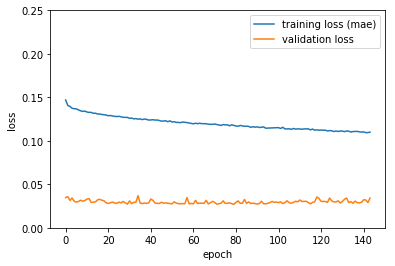

In [11]:
# plot training loss history

def plot_loss(hist_obj):
    plt.plot(hist_obj.history['mean_absolute_error'])
    plt.plot(hist_obj.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training loss (mae)','validation loss'],loc='upper right')
    plt.ylim([0,0.25])
    plt.show()
    
plot_loss(history_object)

In [ ]:
# visualize model

#SVG(model_to_dot(model).create(prog='dot',format='svg'))

Predicted values in range: 6904
Predicted max: 0.919776558876, min: 0.025651851669


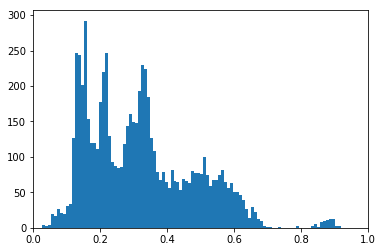

In [12]:
# examine results of model applied to training data

def prediction_histogram(model):
    predicted_values = model.predict(X_data)
    print(u"Predicted values in range: {0}".format(((predicted_values >= 0.0) & (predicted_values <= 1.0)).sum()))
    print(u"Predicted max: {0}, min: {1}".format(predicted_values.max(),predicted_values.min()))
    plt.hist(predicted_values,bins=100)
    plt.xlim(0,1)
    plt.show()
    return predicted_values
    
predicted_values = prediction_histogram(model)

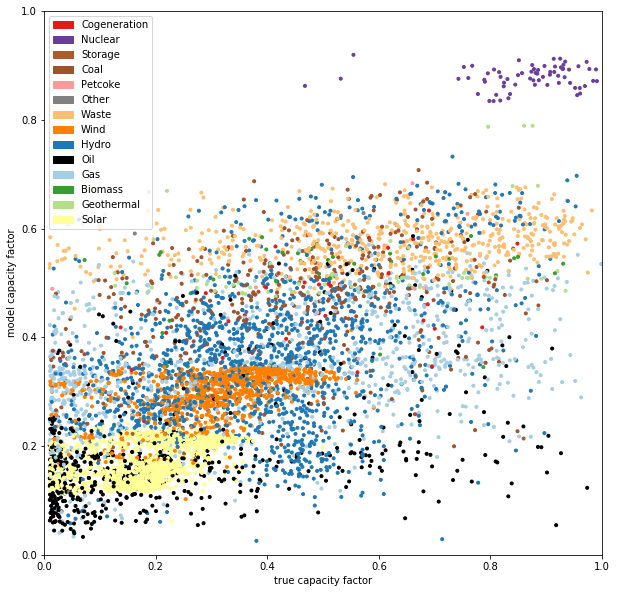

In [13]:
# plot predicted values vs. true values

def plot_predicted(pred_vals):
    label_patches = [mpatches.Patch(color=v,label=k) for k,v in fuel_color.iteritems()]
    fig = plt.figure(figsize=(10,10))
    colors = [fuel_color[fuel_name_list[np.nonzero(onehot)[0][0]]] for onehot in X_data[:,4:]]    
    plt.scatter(y_data,pred_vals,marker='.',c=colors)
    plt.xlabel('true capacity factor')
    plt.ylabel('model capacity factor')
    plt.legend(handles=label_patches,loc='upper left')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.show()
    
plot_predicted(predicted_values)

In [14]:
# calculate simple r2 for training data, model value

r2_score = metrics.r2_score(y_data,predicted_values)
print(u"R2 score: {0}".format(r2_score))

R2 score: 0.40394686122


In [16]:
# try model with different activation to avoid possible dying relu neuron problem

model2 = myNet(activation_type = 'sigmoid')
model2.compile(loss='mean_squared_error',optimizer='rmsprop',metrics=['mean_absolute_error'])
print("Model contains {0} parameters.".format(model2.count_params()))
print(model2.summary())

Model contains 136705 parameters.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 18)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               4864      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_16 (Dense)             (None, 1)    

In [17]:
# fit model
WEIGHTS_FILE2 = "model2/estimate_generation.h5"

# fit model
history_object2 = fit_model(model2,WEIGHTS_FILE2)
                           
# reload model with best weights from training
model2 = myNet(activation_type = 'sigmoid')
model2.load_weights(WEIGHTS_FILE2)
model2.compile(loss='mean_squared_error',optimizer='rmsprop',metrics=['mean_absolute_error'])
print("Finished training; model reloaded with optimum weights.")

Train on 5523 samples, validate on 1381 samples
Epoch 1/512
5523/5523 [==============================] - 1s 214us/step - loss: 0.0559 - mean_absolute_error: 0.1891 - val_loss: 0.0540 - val_mean_absolute_error: 0.1950
Epoch 2/512
5523/5523 [==============================] - 1s 133us/step - loss: 0.0504 - mean_absolute_error: 0.1805 - val_loss: 0.0709 - val_mean_absolute_error: 0.2009
Epoch 3/512
5523/5523 [==============================] - 1s 107us/step - loss: 0.0451 - mean_absolute_error: 0.1653 - val_loss: 0.0516 - val_mean_absolute_error: 0.1743
Epoch 4/512
5523/5523 [==============================] - 0s 90us/step - loss: 0.0416 - mean_absolute_error: 0.1570 - val_loss: 0.0341 - val_mean_absolute_error: 0.1402
Epoch 5/512
5523/5523 [==============================] - 0s 89us/step - loss: 0.0405 - mean_absolute_error: 0.1552 - val_loss: 0.0377 - val_mean_absolute_error: 0.1504
Epoch 6/512
5523/5523 [==============================] - 1s 97us/step - loss: 0.0393 - mean_absolute_error: 0

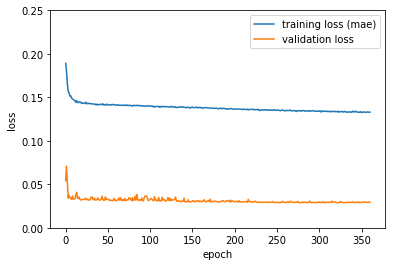

Predicted values in range: 6904
Predicted max: 0.239242643118, min: 0.160212516785


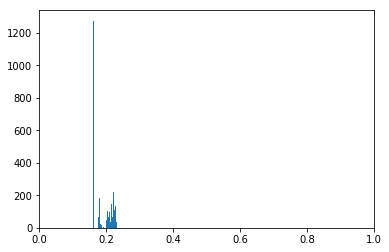

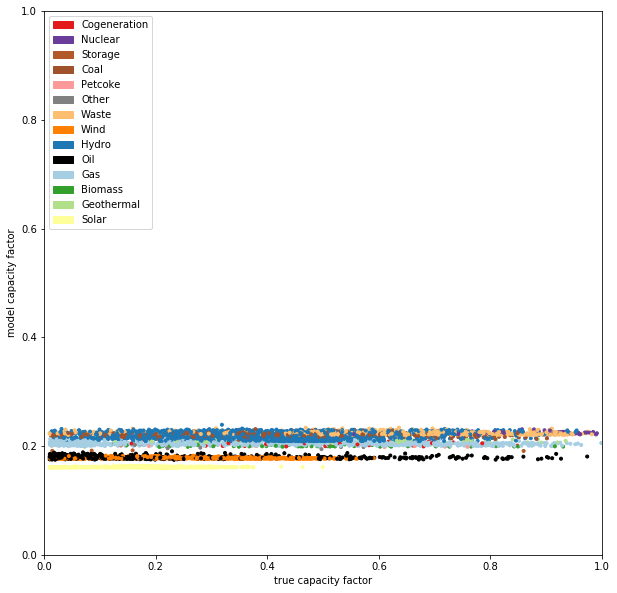

R2 score: -0.346040628527


In [18]:
# examine model fit results
    
plot_loss(history_object2)
predicted_values2 = prediction_histogram(model2)
plot_predicted(predicted_values2)
r2_score = metrics.r2_score(y_data,predicted_values2)
print(u"R2 score: {0}".format(r2_score))

In [19]:
# conclusion: doesn't work!
# try LeakyReLU 

RELU_LEAKAGE = 0.2

def myNet_Leaky():
    model = Sequential()
    model.add(Lambda(lambda x: (x-mean_vals)/range_vals, input_shape = INPUT_SHAPE))   # normalization
    model.add(Dense(DENSE_LAYER_SIZE,activation='linear'))
    model.add(LeakyReLU(alpha=RELU_LEAKAGE))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(DENSE_LAYER_SIZE,activation='linear'))
    model.add(LeakyReLU(alpha=RELU_LEAKAGE))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(DENSE_LAYER_SIZE,activation='linear'))
    model.add(LeakyReLU(alpha=RELU_LEAKAGE))
    model.add(Dense(1,activation='sigmoid'))    # will restrict output to [0,1]
    return model
    
model3 = myNet_Leaky()
model3.compile(loss='mean_squared_error',optimizer='rmsprop',metrics=['mean_absolute_error'])
print("Model contains {0} parameters.".format(model3.count_params()))
print(model3.summary())

Model contains 136705 parameters.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 18)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)  

In [20]:
# fit model
WEIGHTS_FILE3 = "model3/estimate_generation.h5"

# fit model
history_object3 = fit_model(model3,WEIGHTS_FILE3)
                           
# reload model with best weights from training
model3 = myNet_Leaky()
model3.load_weights(WEIGHTS_FILE3)
model3.compile(loss='mean_squared_error',optimizer='rmsprop',metrics=['mean_absolute_error'])
print("Finished training; model reloaded with optimum weights.")

Train on 5523 samples, validate on 1381 samples
Epoch 1/512
5523/5523 [==============================] - 1s 256us/step - loss: 0.0372 - mean_absolute_error: 0.1465 - val_loss: 0.0366 - val_mean_absolute_error: 0.1461
Epoch 2/512
5523/5523 [==============================] - 1s 116us/step - loss: 0.0348 - mean_absolute_error: 0.1402 - val_loss: 0.0388 - val_mean_absolute_error: 0.1539
Epoch 3/512
5523/5523 [==============================] - 1s 97us/step - loss: 0.0348 - mean_absolute_error: 0.1396 - val_loss: 0.0332 - val_mean_absolute_error: 0.1376
Epoch 4/512
5523/5523 [==============================] - 1s 101us/step - loss: 0.0343 - mean_absolute_error: 0.1384 - val_loss: 0.0318 - val_mean_absolute_error: 0.1327
Epoch 5/512
5523/5523 [==============================] - 1s 98us/step - loss: 0.0335 - mean_absolute_error: 0.1366 - val_loss: 0.0310 - val_mean_absolute_error: 0.1306
Epoch 6/512
5523/5523 [==============================] - 1s 100us/step - loss: 0.0336 - mean_absolute_error: 

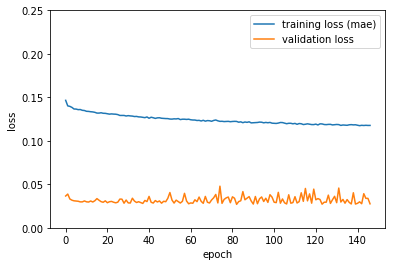

Predicted values in range: 6904
Predicted max: 0.895444750786, min: 0.0111863408238


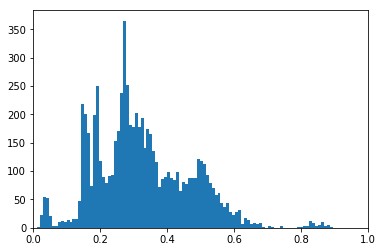

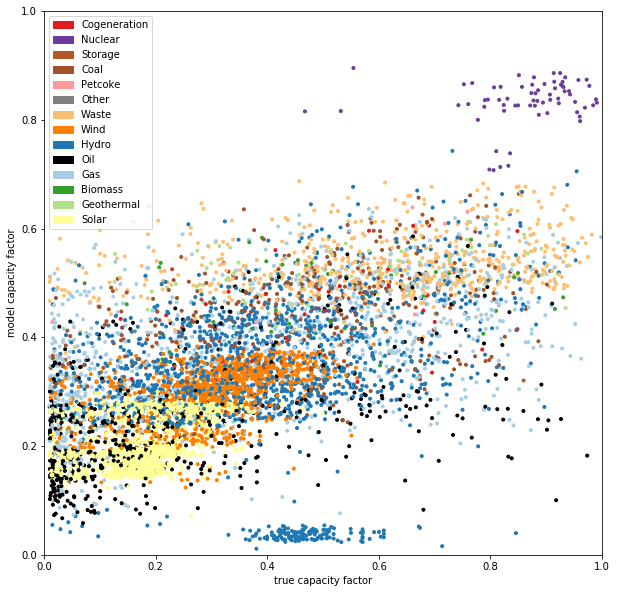

R2 score: 0.377465950709


In [21]:
# examine model fit results
    
plot_loss(history_object3)
predicted_values3 = prediction_histogram(model3)
plot_predicted(predicted_values3)
r2_score = metrics.r2_score(y_data,predicted_values3)
print(u"R2 score: {0}".format(r2_score))